In [321]:
import pandas as pd
import numpy as np
import datetime
import json
import re
import matplotlib.pyplot as plt

In [349]:
def convert_price(str_price):
    if type(str_price) != str:
        return str_price
    if ('－' in str_price) | ('なし' in str_price):
        return 0.0
    elif '万円' in str_price:
        return float(str_price.replace('万円', '').replace(',', ''))*10000
    else:
        return float(str_price.replace('円', '').replace(',', ''))
    
    
def convert_area(str_area):
    if type(str_area) != str:
        return str_area
    if ('－' in str_area) | ('なし' in str_area):
        return 0.0
    elif ',' in str_area:
        #これは異常値なのでNaNを返す
        return np.nan
    else:
        return float(str_area.replace('m²', '').replace('（壁芯）','').replace('（内法）', ''))
    
def convert_age(str_age):
    if type(str_age) != str:
        return str_age
    pos_y = str_age.find('年')
    year = int(str_age[0:pos_y])
    pos_m = str_age.find('月')
    month = int(str_age[pos_y+1:pos_m])
    
    return (datetime.date.today().year - year)*12 + datetime.date.today().month - month

def convert_tosu(str_tosu):
    if type(str_tosu) != str:
        return str_tosu
    if str_tosu == '－':
        #これは欠損値なのでとりあえずNaNを返す
        return np.nan
    return int(str_tosu.replace('戸', '').replace(',', ''))

def convert_floor(str_floor):
    if type(str_floor) != str:
        return str_floor
    if str_floor == '－':
        # これは欠損値
        return np.nan
    pos_floor = str_floor.find('階')
    # 地下室は負の値にする
    return int(str_floor[0:pos_floor].replace('メゾネット', '').replace('地下','-'))
    

def convert_total_floor(str_floor):
    if type(str_floor) != str:
        return str_floor
    if str_floor == '－':
        # これは欠損値
        return np.nan
    pos_total_floor = str_floor.find('階')
    return int(str_floor[0:pos_total_floor].replace('地上', ''))

def convert_madori(str_madori):
    if str_madori == '－':
        return np.nan
    pos_madori = str_madori.find('(')
    if pos_madori > 0:
        str_madori = str_madori[0:pos_madori]
    
    rank = 0
    if str_madori == 'ワンルーム':
        rank = 16
    else:
        str_madori = str_madori.replace('１', '1')
        str_madori = str_madori.replace('２', '2')
        str_madori = str_madori.replace('３', '3')
        str_madori = str_madori.replace('４', '4')
        str_madori = str_madori.replace('５', '5')
        str_madori = str_madori.replace('６', '6')
        str_madori = str_madori.replace('７', '7')
        str_madori = str_madori.replace('８', '8')
        str_madori = str_madori.replace('９', '9')
        lists=re.findall(r'([0-9]*)',str_madori)
        rank = int(lists[0])*16
        if 'Ｓ' in str_madori:
            rank += 1
        if 'Ｋ' in str_madori:
            rank += 2
        if 'Ｄ' in str_madori:
            rank += 4
        if 'Ｌ' in str_madori:
            rank += 8
    return rank

def convert_parking(str_parking):
    if type(str_parking) != str:
        return str_parking
    pos = str_parking.find('有')
    if pos >= 0:
        return 1
    else:
        return 0

def convert_eki(str_koutu):
    if type(str_koutu) != str:
        return str_koutu
    pos = str_koutu.find('/')
    str_eki = str_koutu[pos+1:].strip()
    return str_eki
    
def convert_toho(str_koutu):
    if type(str_koutu) != str:
        return str_koutu
    pos_toho = str_koutu.find('徒歩')
    if pos_toho < 0:
        return np.nan
    pos_hun = str_koutu.find('分')
    str_hun = str_koutu[pos_toho+2:pos_hun].replace(' ','')
    try:
        hun = int(str_hun)
        return hun
    except:
        print(str_koutu)
        return 0
    
def convert_moyorieki(str_time):
    if type(str_time) != str:
        return str_time
    pos = str_time.find('分')
    return int(str_time[:pos])

In [350]:
df_data_ori = pd.read_csv('./data/bunjou_2018-5-29.csv')

In [351]:
#建物構造はSRCかRCまたはSRCとRCの混合が全てで、木造の物件がなかったため除外
delete_column = ['タイトル', 'その他交通', '所在地', '物件種目', '平米単価', '借地期間・地代（月額）', '権利金', '敷金 / 保証金', '維持費等',
                'その他一時金', '不要', '建物名・部屋番号', '建物状況調査　/　瑕疵保険・保証', '備考', '建物構造','リフォーム履歴', 'リノベーション履歴', 'バイク置き場',
                 '駐輪場', 'ペット', '敷地面積', '管理形態・方式', '国土法届出', '条件等', '現況', '引渡し', '物件番号',
                 '情報公開日', '次回更新予定日']

In [352]:
df_data_ori.columns

Index(['タイトル', '交通', 'その他交通', '所在地', '物件種目', '価格', '平米単価', '管理費等', '修繕積立金',
       '借地期間・地代（月額）', '権利金', '敷金 / 保証金', '維持費等', 'その他一時金', '不要', '建物名・部屋番号',
       '設備', '建物状況調査　/　瑕疵保険・保証', '備考', '間取り', '専有面積', 'バルコニー', '階建 / 階',
       '建物構造', '築年月', '総戸数', 'リフォーム履歴', 'リノベーション履歴', '駐車場', 'バイク置き場', '駐輪場',
       'ペット', '土地権利', '敷地面積', '管理形態・方式', '国土法届出', '条件等', '現況', '引渡し', '物件番号',
       '情報公開日', '次回更新予定日'],
      dtype='object')

In [353]:
df_kari = df_data_ori
df_kari = df_kari.drop(delete_column, axis=1)

In [354]:
price_column = ['価格', '管理費等', '修繕積立金']
area_column = ['専有面積', 'バルコニー']
for key in price_column:
    df_kari[key] = df_kari[key].map(convert_price)
for key in area_column:
    df_kari[key] = df_kari[key].map(convert_area)
    
df_kari['築年月'] = df_kari['築年月'].map(convert_age)
df_kari['総戸数'] = df_kari['総戸数'].map(convert_tosu)
df_kari['間取り'] = df_kari['間取り'].map(convert_madori)
df_kari['駐車場'] = df_kari['駐車場'].map(convert_parking)

df_floor = df_kari['階建 / 階'].str.split(' /', expand=True)
df_floor.columns = ['総階数', '階']
df_floor['総階数'] = df_floor['総階数'].map(convert_total_floor)
df_floor['階'] = df_floor['階'].map(convert_floor)
df_kari = pd.concat([df_kari, df_floor], axis=1)
df_kari = df_kari.drop('階建 / 階', axis=1)

df_transit = df_kari['交通'].str.split('駅', expand=True)
df_transit.columns = ['最寄り駅','駅から']
df_transit['最寄り駅'] = df_transit['最寄り駅'].map(convert_eki)
df_transit['駅から'] = df_transit['駅から'].map(convert_toho)
df_kari = pd.concat([df_kari, df_transit], axis=1)
df_kari = df_kari.drop('交通', axis=1)

df_kari.to_csv('list_eki.csv', columns=['最寄り駅'], index=False, header=False)

In [355]:
f = open('time_FromShinjuku.json', 'r', encoding='utf-8')
timeFromShinjuku_dict = json.load(f)
df_kari['最寄り駅'] = df_kari['最寄り駅'].map(timeFromShinjuku_dict)
df_kari['最寄り駅'] = df_kari['最寄り駅'].map(convert_moyorieki)

In [356]:
opts = {}
for i in range(0, len(df_kari['設備'])):
    #if df_kari['設備'][i]:
    setubi = df_kari['設備'][i].split("、")
    for j in range(0, len(setubi)):
        if setubi[j] in opts:
            opts[setubi[j]] += 1
        else:
            opts[setubi[j]] = 1
            
pd.DataFrame.from_dict(opts, orient='index').sort_values(by=0, ascending=False) 

,0
エレベーター,3000
システムキッチン,2721
都市ガス,2370
浴室乾燥機,2353
追焚機能,2241
温水洗浄便座,2239
室内洗濯機置場,2214
オートロック,2008
給湯,1965
収納スペース,1949


In [357]:
opts_columns = {'浴室乾燥機': [], '温水洗浄便座': [], '追焚機能': [], 'オートロック': [], '宅配ＢＯＸ': [], '食器洗浄乾燥機': [], '床暖房': []}
for key in opts_columns:
    for i in range(0, len(df_kari)):
        opts_columns[key].append(1 if key in df_kari['設備'][i] else 0)
        
df_setubi = pd.DataFrame(opts_columns)
df_kari = pd.concat([df_kari, df_setubi], axis=1)
df_kari = df_kari.drop('設備', axis=1)

In [358]:
abnormal_data = []    
for i in range(0, len(df_kari.index)):
    for key in df_kari.columns:
        if pd.isnull(df_kari[key][i]):
            abnormal_data.append(i)
#print(abnormal_data)
#df_kari = df_kari.drop(abnormal_data, axis=0).reset_index(drop=True)
df_kari = df_kari.dropna(how='any').reset_index(drop='true')
df_kari = df_kari.drop_duplicates()

In [359]:
df_kari.to_csv('bunjou_cleaned.csv', index=True)

In [360]:
df_kari

,価格,管理費等,修繕積立金,間取り,専有面積,バルコニー,築年月,総戸数,駐車場,土地権利,...,階,最寄り駅,駅から,浴室乾燥機,温水洗浄便座,追焚機能,オートロック,宅配ＢＯＸ,食器洗浄乾燥機,床暖房
0,15800000.0,9540.0,8200.0,46,57.98,6.72,468,133.0,0,所有権,...,3,39.0,3.0,0,1,0,0,0,0,0
1,17500000.0,8000.0,10000.0,54,55.83,9.10,551,110.0,1,所有権,...,2,35.0,4.0,0,1,0,0,0,0,0
2,17800000.0,10012.0,7400.0,62,61.60,7.60,454,302.0,0,所有権,...,10,39.0,4.0,0,1,0,0,0,0,0
3,17800000.0,10500.0,20000.0,46,57.42,2.60,530,22.0,0,所有権,...,3,29.0,5.0,1,1,1,0,0,0,0
4,18000000.0,16765.0,15260.0,54,55.00,5.58,308,21.0,0,旧法賃借権,...,2,29.0,4.0,0,1,1,0,0,0,0
5,18900000.0,16765.0,15260.0,46,55.00,5.58,307,21.0,0,旧法賃借権,...,4,29.0,4.0,0,0,0,0,0,0,0
6,19800000.0,12270.0,18590.0,38,61.97,6.65,444,28.0,0,所有権,...,2,29.0,11.0,0,1,0,0,0,0,0
7,19800000.0,10000.0,16900.0,54,60.20,10.36,463,40.0,0,所有権,...,2,46.0,1.0,0,0,1,0,0,0,0
8,19800000.0,10000.0,16900.0,54,60.20,10.36,463,43.0,0,所有権,...,2,46.0,1.0,0,0,0,0,0,0,0
9,19800000.0,11500.0,13400.0,47,68.87,6.30,587,41.0,0,旧法賃借権,...,5,34.0,4.0,0,0,0,0,0,0,0


(array([ 14.,  98., 271., 599., 611., 489., 350., 274., 317., 179., 144.,
        143.,  93.,  50.,  55.,  47.,  68.,  35.,  42.,  23.]),
 array([1.45000e+07, 2.12750e+07, 2.80500e+07, 3.48250e+07, 4.16000e+07,
        4.83750e+07, 5.51500e+07, 6.19250e+07, 6.87000e+07, 7.54750e+07,
        8.22500e+07, 8.90250e+07, 9.58000e+07, 1.02575e+08, 1.09350e+08,
        1.16125e+08, 1.22900e+08, 1.29675e+08, 1.36450e+08, 1.43225e+08,
        1.50000e+08]),
 <a list of 20 Patch objects>)

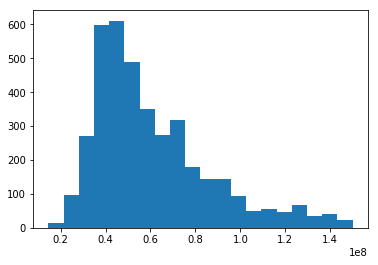

In [348]:
plt.hist(df_kari['価格'].values, bins=20, range=(df_kari['価格'].values.min(), 150000000))